### Data Collection

In [2]:
import pandas as pd 
from pyspark.sql import SparkSession 
import numpy as np

In [22]:
df = pd.read_csv("AB_NYC_2019.csv") 
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [10]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns[4:]
numeric_cols

Index(['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

### Detect and remove outliers using percentile method

In [ ]:
# As we see price, minimum_nights, calculated_host_listings_count has outliers 

In [23]:
df_shape = df.shape 
df_shape

(48895, 16)

In [41]:
df2 = df[:]

In [42]:
cols = ["price", "minimum_nights", "calculated_host_listings_count"]
for col in cols: 
    # remove outliers lower_limit = 0.001, upper_limit = 99.999 
    lower_limit = df2[col].quantile(0.01) 
    upper_limit = df2[col].quantile(0.999) 
    print(lower_limit, upper_limit)

    # remove such outliers 
    df2 = df2[(df2[col] > lower_limit) & (df2[col] < upper_limit)]

30.0 3000.0
1.0 358.90800000003946
1.0 327.0


In [43]:
df2.shape

(11139, 16)

In [27]:
df2.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         2
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [ ]:
# since the host_name is not much weighted for any model feeding, we can ignore it.

In [45]:
# So now my dataset is free of outliers.... ? 

# Of-course yes, but this looks we are loosing so much of data
# this is bcz we are considering a bit more number of cols 
# what-if target on our most imp col i.e., `price`

### Outliers removal only on `price` col 

In [46]:
lower_limit = df2[col].quantile(0.01) 
upper_limit = df2[col].quantile(0.999) 
df_new = df[(df['price'] > lower_limit) & (df['price'] < upper_limit)] 
df_new.shape

(42020, 16)

In [48]:
# looks fine ? 
df_new.price.describe()

count    42020.000000
mean       105.889957
std         51.565719
min         10.000000
25%         65.000000
50%         98.000000
75%        146.000000
max        231.000000
Name: price, dtype: float64

### Using bell graph

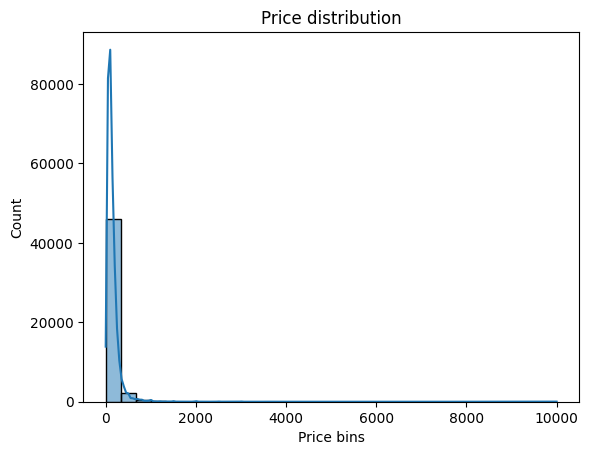

In [55]:
# histplot for `df`
import matplotlib.pyplot as plt 
import seaborn as sns

sns.histplot(df.price, bins=30, kde=True) # sns.kdeplot(df.price, color='green', fill=True) 
plt.xlabel('Price bins') 
plt.ylabel('Count') 
plt.title('Price distribution') 
plt.show()

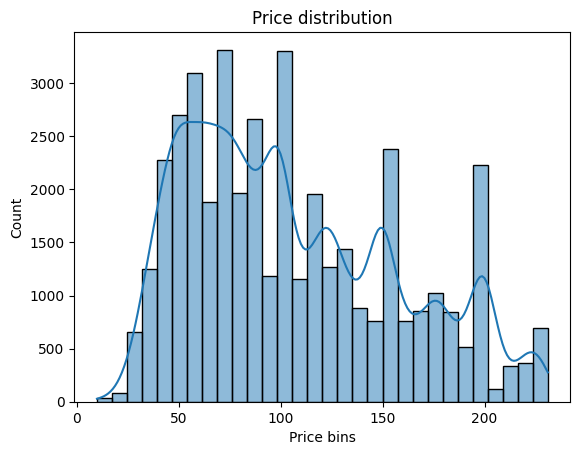

In [58]:
# for `df_new`
import matplotlib.pyplot as plt 
import seaborn as sns

sns.histplot(df_new.price, bins=30, kde=True) # sns.kdeplot(df.price, color='green', fill=True) 
plt.xlabel('Price bins') 
plt.ylabel('Count') 
plt.title('Price distribution') 
plt.show()

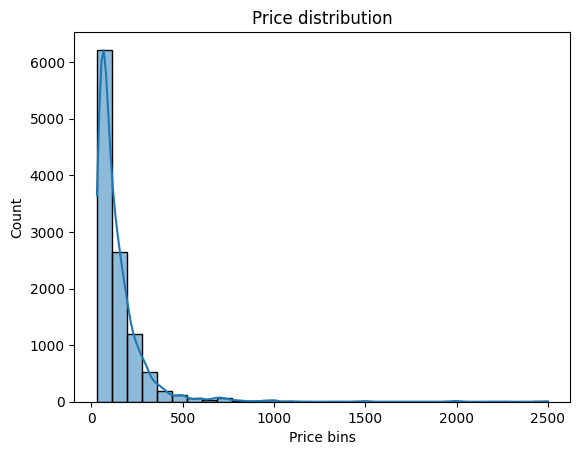

In [59]:
# for `df2`
import matplotlib.pyplot as plt 
import seaborn as sns

sns.histplot(df2.price, bins=30, kde=True) # sns.kdeplot(df.price, color='green', fill=True) 
plt.xlabel('Price bins') 
plt.ylabel('Count') 
plt.title('Price distribution') 
plt.show()

### Note:- 

1. `df2` is fine, but it ignoring a lot of data, which is not feasible
2. `df_new` is suitable in all aspects
3. `df` if full of outliers